1. Dane przygotowanie

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Funkcje pomocnicze

In [3]:
def plot_prediction(train_data=None, train_labels=None, test_data=None, test_labels=None, predictions=None):
    plt.figure(figsize=(7, 4))
    plt.scatter(train_data, train_labels, c='b', s=4, label="Train")
    plt.scatter(test_data, test_labels, c='g', s=4, label="Test")
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Preds")
    plt.legend(prop={'size':14});

# def plot_train_data(loosLoop=None):
#     plt.figure(figsize=(7, 4))
#     plt.plot()
#     plt.legend(prop={'size':14});
    

## 1. Dane przygotowanie

In [4]:
# regresja liniowa, linia y = ax + b 
a = 0.7 
b = 0.3
X = torch.arange(start=0, end=1, step=0.02).unsqueeze(dim=1) # unsqueeze potrzebne do nn, dodanie dodatkowego wymiaru
y = a * X + b
# a i b są znane tylko do stworzenia danych, model NN ich nie zna

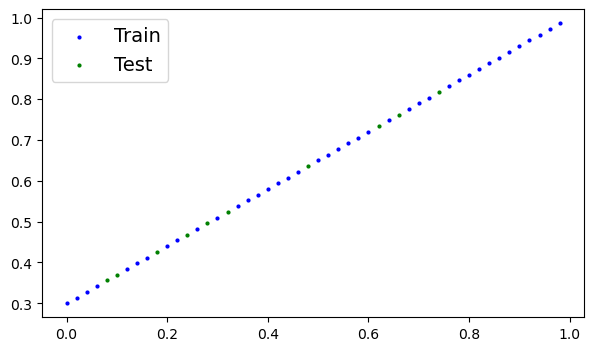

In [5]:
# rozdzielenie danych na treningowe i testowe
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
plot_prediction(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test)

## 2. Budowanie modelu

Dwa algorytmy sterujące.
1. Gradient descent https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=2
2. Backpropagation https://www.youtube.com/watch?v=Ilg3gGewQ5U&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=3

In [6]:
# definicja klasy modelu która dziedziczy z nn.Module która jest bazową klasą neural networks
class ModelNN(nn.Module):
    def __init__(self):
        super().__init__()
        # inicjalizacja parametrów, które są wartościami poszukiwanymi, inicjalizacja random
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        # metoda która oblicza model, jest wymagana w każdym modelu
    def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" to dane wejściowe
        return self.a * x + self.b       

### Instancja modelu

In [7]:
torch.manual_seed(42)
model = ModelNN()
# parametry po utworzeniu objektu, pierwszy random
# list(model.parameters()) # sposób na same wartości
model.state_dict() # wartości parametrów wraz z nazwami

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])

In [8]:
print(f'a->{a}, b->{b}') # dla porównywalnia wartości jakie powinny być

a->0.7, b->0.3


### Pierwsze przewidywania bez uczenia modelu 
https://pytorch.org/docs/stable/generated/torch.inference_mode.html

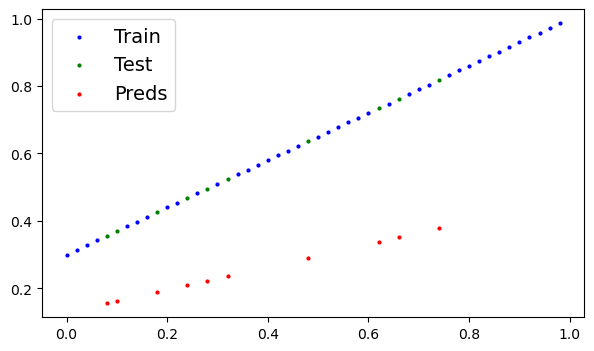

In [9]:
with torch.inference_mode(): # tryb bez uczenia w celu testowym po prostu dane obliczane są przez model, nie ważne czy wyszkolony czy nie.
    y_preds = model(X_test)
plot_prediction(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_preds)    

## 3. Trenowanie modelu

### Loss function - funkcja która mierzy jak bardzo przewidywania mijają się z danymi testowymi
https://pytorch.org/docs/stable/nn.html#loss-functions
### Optimizer - dopasowuje parametry modelu tak żeby poprawić wyniki loss function
https://pytorch.org/docs/stable/optim.html

In [10]:
# ustawienie funkcji różnic
loss_fn = nn.L1Loss()
# ustawienie optimizera
optimizer = torch.optim.SGD(params=model.parameters(), # szukane parametry
                            lr=0.005) # częstotliwość uczenia, wg. dokładności parametrów                    

In [11]:
# pętla trenowania
epochs = 300 # ilość pętli uczenia

epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model.train() # Ustawienie modułu w trybie treningowym.
    y_pred = model(X_train) # tu się uruchamia funkcja forward
    loss = loss_fn(y_pred, y_train) # obliczenie różnic
    optimizer.zero_grad() # optymalizacja parametrów, Resetuje gradienty wszystkich zoptymalizowanych :class:`torch.Tensor` s.
    loss.backward() # backpropagation, Oblicza gradient tensora aktualnego względem elementów grafu.
    optimizer.step() # Wykonuje pojedynczy krok optymalizacji.
   
    model.eval() # Ustawienie modułu w trybie oceny.
    with torch.inference_mode(): # tryb bez uczenia w celu testowym po prostu dane obliczane są przez model, nie ważne czy wyszkolony czy nie.
        test_preds = model(X_test)
        test_loss = loss_fn(test_preds, y_test)

    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)


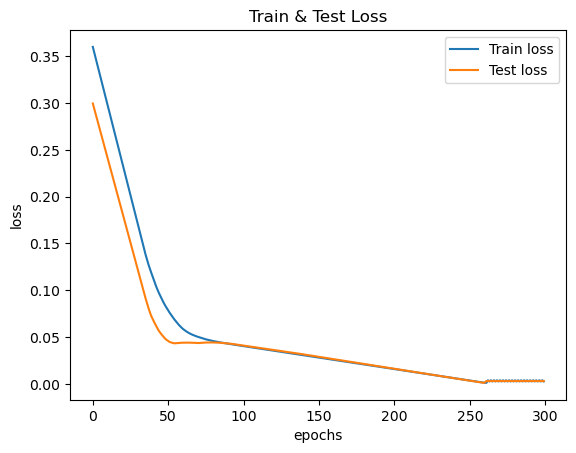

In [12]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Train & Test Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend();

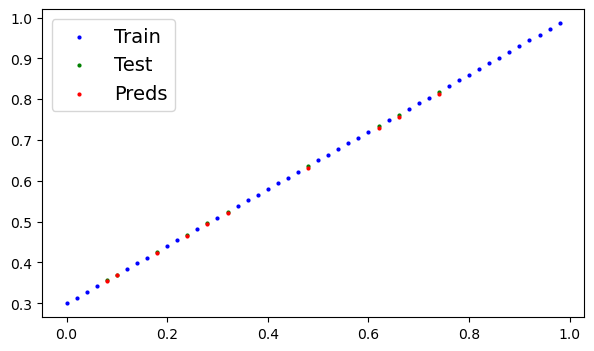

In [13]:
plot_prediction(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=test_preds)  

In [14]:
model.state_dict() # wartości parametrów wraz z nazwami

OrderedDict([('a', tensor([0.6955])), ('b', tensor([0.2986]))])

In [15]:
print(f'a->{a}, b->{b}') # dla porównywalnia wartości jakie powinny być

a->0.7, b->0.3
